In [1]:
import os
import sys

os.environ["PYSPARK_PYTHON"]="C:\Spark\spark-3.3.2-bin-hadoop2\python"
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-18.0.2.1"
os.environ["SPARK_HOME"] = "C:\Spark\spark-3.3.2-bin-hadoop2"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.9.5-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

MAX_MEMORY = "14G"
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("cluster_predict") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()    
spark

In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)

In [3]:
model_data = spark.read.option("header","true").option("inferSchema","true").csv("../data/EDA/final_data_for_modelling.csv")
model_data = model_data.drop("_c0")
model_data.printSchema()
model_data.count()

root
 |-- age_imputed: double (nullable = true)
 |-- bg2_lactate_imputed: double (nullable = true)
 |-- basophils_imputed: double (nullable = true)
 |-- eosinophils_imputed: double (nullable = true)
 |-- lymphocytes_imputed: double (nullable = true)
 |-- monocytes_imputed: double (nullable = true)
 |-- neutrophils_imputed: double (nullable = true)
 |-- albumin_imputed: double (nullable = true)
 |-- aniongap_imputed: double (nullable = true)
 |-- bicarbonate_imputed: double (nullable = true)
 |-- bun_imputed: double (nullable = true)
 |-- calcium_imputed: double (nullable = true)
 |-- chloride_imputed: double (nullable = true)
 |-- creatinine_imputed: double (nullable = true)
 |-- glucose_imputed: double (nullable = true)
 |-- sodium_imputed: double (nullable = true)
 |-- potassium_imputed: double (nullable = true)
 |-- inr_imputed: double (nullable = true)
 |-- pt_imputed: double (nullable = true)
 |-- ptt_imputed: double (nullable = true)
 |-- hematocrit_imputed: double (nullable = tr

63887

In [4]:
import pyspark.sql.functions as F
model_data = model_data.withColumn("gender_imputed", F.when(F.col("gender") == 'M', 1) \
                           .when(F.col("gender") == 'F', 2) \
                           .otherwise(0))
model_data.groupby("gender_imputed").count().toPandas()

,gender_imputed,count
0,1,29404
1,2,34483


In [5]:
# data transfo
feature_cols =  model_data.columns
feature_cols.remove("charlson_comorbidity_index_imputed")
feature_cols.remove("gender")
#feature_cols.append("gender_imputed")
print(feature_cols)


['age_imputed', 'bg2_lactate_imputed', 'basophils_imputed', 'eosinophils_imputed', 'lymphocytes_imputed', 'monocytes_imputed', 'neutrophils_imputed', 'albumin_imputed', 'aniongap_imputed', 'bicarbonate_imputed', 'bun_imputed', 'calcium_imputed', 'chloride_imputed', 'creatinine_imputed', 'glucose_imputed', 'sodium_imputed', 'potassium_imputed', 'inr_imputed', 'pt_imputed', 'ptt_imputed', 'hematocrit_imputed', 'hemoglobin_imputed', 'mch_imputed', 'mchc_imputed', 'mcv_imputed', 'platelet_imputed', 'rbc_imputed', 'rdw_imputed', 'wbc_imputed', 'scr_min_imputed', 'ckd_imputed', 'mdrd_est_imputed', 'scr_baseline_imputed', 'alt_imputed', 'alp_imputed', 'ast_imputed', 'bilirubin_total_imputed', 'gender_imputed']


In [6]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
train, test = model_data.randomSplit([0.7,0.3])
print("Size of training data {0}".format(train.count()))
print("Size of test data {0}".format(test.count()))

Size of training data 44613
Size of test data 19274


In [7]:
from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans

In [50]:
X_train = train.select([c for c in feature_cols]).toPandas()
X_test = test.select([c for c in feature_cols]).toPandas()

In [51]:
y_train = train.select("charlson_comorbidity_index_imputed").toPandas()
y_test = test.select("charlson_comorbidity_index_imputed").toPandas()

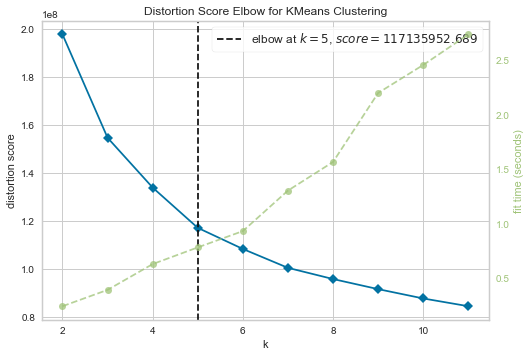

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# find the optimum k values
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(X_train)    # Fit the data to the visualizer
visualizer.show()    # Finalize and render the figure

optimum K value is 5

In [52]:
kmeans_model = KMeans(5)
X_train_clusters = kmeans_model.fit_predict(X_train)
X_train["cluster"] = X_train_clusters.tolist()

In [53]:
X_train["cluster"].value_counts()

0    14275
1    10617
4     9910
3     5355
2     4456
Name: cluster, dtype: int64

In [54]:
clusters = kmeans_model.predict(X_test)
X_test["cluster"] = clusters.tolist()
X_test["cluster"].value_counts()

0    6154
1    4572
4    4321
3    2293
2    1934
Name: cluster, dtype: int64

In [55]:
from sklearn import metrics
metrics.silhouette_score(X_test, clusters, metric='euclidean')

0.2324662381266973

C:\Users\snksh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


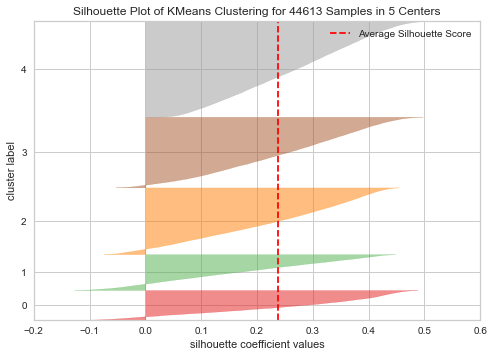

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 44613 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [16]:

visualizer = SilhouetteVisualizer(kmeans_model)
cols = [col for col in X_test.columns.values]
cols.remove("cluster")
visualizer.fit(X_test[cols])    # Fit the data to the visualizer
visualizer.show()    # Finalize and render the figure

C:\Users\snksh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


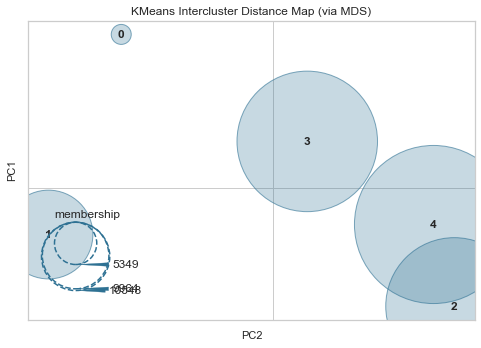

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [17]:
visualizer = InterclusterDistance(kmeans_model)

visualizer.fit(X_test[cols])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


Silhouette Score is the mean Silhouette Coefficient for all clusters, which is calculated using the mean intra-cluster distance and the mean nearest-cluster distance. This score is between -1 and 1, where the higher the score the more well-defined and distinct your clusters are.

### Prediction

In [56]:
print(len(X_train))
print(len(y_train))

44613
44613


In [57]:
print(len(X_test))
print(len(y_test))

19274
19274


In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
to_scale = [col for col in X_train.columns.values]
to_scale.remove("cluster")
to_scale.remove("gender_imputed")
print(to_scale)


['age_imputed', 'bg2_lactate_imputed', 'basophils_imputed', 'eosinophils_imputed', 'lymphocytes_imputed', 'monocytes_imputed', 'neutrophils_imputed', 'albumin_imputed', 'aniongap_imputed', 'bicarbonate_imputed', 'bun_imputed', 'calcium_imputed', 'chloride_imputed', 'creatinine_imputed', 'glucose_imputed', 'sodium_imputed', 'potassium_imputed', 'inr_imputed', 'pt_imputed', 'ptt_imputed', 'hematocrit_imputed', 'hemoglobin_imputed', 'mch_imputed', 'mchc_imputed', 'mcv_imputed', 'platelet_imputed', 'rbc_imputed', 'rdw_imputed', 'wbc_imputed', 'scr_min_imputed', 'ckd_imputed', 'mdrd_est_imputed', 'scr_baseline_imputed', 'alt_imputed', 'alp_imputed', 'ast_imputed', 'bilirubin_total_imputed']


In [59]:
scaler.fit(X_train[to_scale])

StandardScaler()

In [60]:
X_train[to_scale] = scaler.transform(X_train[to_scale])

# predict z-scores on the test set
X_test[to_scale] = scaler.transform(X_test[to_scale])

In [61]:
from sklearn.linear_model import LinearRegression
X_train["charlson_comorbidity_index"] = y_train
X_test["charlson_comorbidity_index"] = y_test
y_train_res =  []
y_train_res_predict =  []
y_test_res =  []
y_test_res_predict =  []
for i in range(5):
    print(i)
    X_tr = X_train.loc[X_train.cluster == i]
    y_tr = X_tr.charlson_comorbidity_index.values
    X_t = X_test.loc[X_test.cluster == i]
    y_t = X_t.charlson_comorbidity_index.values
    #print(X_t)
    X_tr = X_tr.drop(columns=["cluster","charlson_comorbidity_index"])
    X_t = X_t.drop(columns=["cluster","charlson_comorbidity_index"])
    regr = LinearRegression()
    model = regr.fit(X_tr, y_tr)
    y_train_predict = model.predict(X_tr)
    y_test_predict = model.predict(X_t)
    print(regr.score(X_t, y_t))
    y_train_res.extend(y_tr)
    y_train_res_predict.extend(y_train_predict)
    y_test_res.extend(y_t)
    y_test_res_predict.extend(y_test_predict)

0
0.6277219620538432
1
0.5896571933526084
2
0.5307744353743642
3
0.42275240132069214
4
0.5702642542355805


In [62]:
print(len(y_train_res))
print(len(y_train_res_predict))
print(len(y_test_res))
print(len(y_test_res_predict))

44613
44613
19274
19274


In [63]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_train_res, y_train_res_predict), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_train_res, y_train_res_predict), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_train_res, y_train_res_predict), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_train_res, y_train_res_predict), 2)) 
print("R2 score =", round(sm.r2_score(y_train_res, y_train_res_predict), 2))

Mean absolute error = 1.12
Mean squared error = 2.56
Median absolute error = 0.84
Explain variance score = 0.6
R2 score = 0.6


In [64]:
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test_res, y_test_res_predict), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test_res, y_test_res_predict), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test_res, y_test_res_predict), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test_res, y_test_res_predict), 2)) 
print("R2 score =", round(sm.r2_score(y_test_res, y_test_res_predict), 2))

Mean absolute error = 1.13
Mean squared error = 2.65
Median absolute error = 0.84
Explain variance score = 0.59
R2 score = 0.59


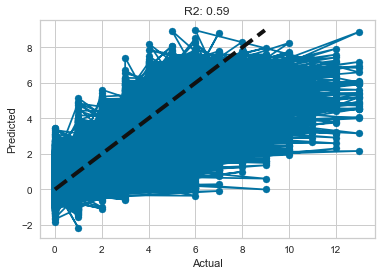

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

fig, ax = plt.subplots()
ax.scatter(y_test_res, y_test_res_predict)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

#y_test.reshape
y_test_1, y_test_pred_1 = pd.DataFrame(y_test_res).values.reshape(-1,1), pd.DataFrame(y_test_res_predict).values.reshape(-1,1)
ax.plot(y_test_1, y_test_pred_1)


ax.plot([min(y_test_res), max(y_test_res_predict)], [min(y_test_res), max(y_test_res_predict)], 'k--', lw=4)

ax.set_title('R2: ' + str(round(sm.r2_score(y_test_res, y_test_res_predict), 2)))
plt.show()